In [1]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2

## Optical digits

In [2]:
train_file = './uci_repos/optical_digits/optdigits.tra'
test_file = './uci_repos/optical_digits/optdigits.tes'
column = ['pixel_'+str(i) for i in range(64)]
column.append('digit_label')
train_data = pd.read_csv(train_file, sep=',', header=None, names=column)
test_data = pd.read_csv(test_file, sep=',', header=None, names=column)

In [3]:
test_data.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_55,pixel_56,pixel_57,pixel_58,pixel_59,pixel_60,pixel_61,pixel_62,pixel_63,digit_label
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4


In [4]:
train_y = train_data.iloc[:,-1:].copy().to_numpy()
train_images = train_data.iloc[:, 0:-1].copy().to_numpy()
test_y = test_data.iloc[:,-1:].copy().to_numpy()
test_images = test_data.iloc[:, 0:-1].copy().to_numpy()

In [5]:
np.unique(test_y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

train image size :  (3823, 64)
train y size :  (3823, 10)
test image size :  (1797, 64)
test y size :  (1797, 10)
sample y : [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


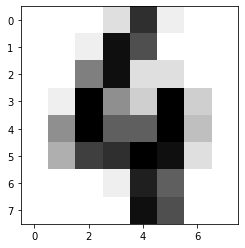

In [6]:
#train_images = [np.reshape(x, (8,8, 1)) for x in train_images ]
train_images = np.array(train_images).astype(np.float32) / 16.0
#test_images = [np.reshape(x, (8,8, 1)) for x in test_images ]
test_images = np.array(test_images).astype(np.float32) / 16.0

train_y = tf.keras.utils.to_categorical(train_y, num_classes=10, dtype='float32')
test_y = tf.keras.utils.to_categorical(test_y, num_classes=10, dtype='float32')
print('train image size : ', train_images.shape)
print('train y size : ', train_y.shape)
print('test image size : ', test_images.shape)
print('test y size : ', test_y.shape)
print('sample y :', train_y[0])
plt.imshow(np.reshape(train_images[100],(8,8)), cmap=plt.cm.gray_r, interpolation='nearest')

### VAE

In [7]:
import tensorflow.compat.v1  as tf
tf.disable_v2_behavior()
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import os
import numpy as np

mb_size = 64
z_dim = 10
X_dim = 64
y_dim = 10
h_dim = 16
lr = 1e-3


def plot(samples):
    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(8, 8)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(8, 8), cmap='Greys_r')

    return fig


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random.normal(shape=size, stddev=xavier_stddev)


# Q(z|X) 

X = tf.keras.Input(shape=(X_dim,))
c = tf.keras.Input(shape=(y_dim,))
z = tf.keras.Input(shape=(z_dim,))

Q_W1 = tf.Variable(xavier_init([X_dim + y_dim, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]))

Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]))


def Q(X, c):
    inputs = tf.concat(axis=1, values=[X, c])
    h = tf.nn.relu(tf.matmul(inputs, Q_W1) + Q_b1)
    z_mu = tf.matmul(h, Q_W2_mu) + Q_b2_mu
    z_logvar = tf.matmul(h, Q_W2_sigma) + Q_b2_sigma
    return z_mu, z_logvar


def sample_z(mu, log_var):
    eps = tf.random.normal(shape=tf.shape(mu))
    return mu + tf.exp(log_var / 2) * eps


# P(X|z)

P_W1 = tf.Variable(xavier_init([z_dim + y_dim, h_dim]))
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

P_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
P_b2 = tf.Variable(tf.zeros(shape=[X_dim]))


def P(z, c):
    inputs = tf.concat(axis=1, values=[z, c])
    h = tf.nn.relu(tf.matmul(inputs, P_W1) + P_b1)
    logits = tf.matmul(h, P_W2) + P_b2
    prob = tf.nn.sigmoid(logits)
    return prob, logits

z_mu, z_logvar = Q(X, c)
z_sample = sample_z(z_mu, z_logvar)
_, logits = P(z_sample, c)

# Sampling from random z
X_samples, _ = P(z, c)

# E[log P(X|z)]
recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X), 1)
kl_loss = 0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)

# VAE loss
vae_loss = tf.reduce_mean(recon_loss + kl_loss)

# gradient step
solver = tf.compat.v1.train.AdamOptimizer().minimize(vae_loss)
sess = tf.compat.v1.Session ()
sess.run(
tf.compat.v1.global_variables_initializer())

if not os.path.exists('samples/'):
    os.makedirs('samples/')

i = 0

for it in range(100000):
    ind = np.random.choice(train_images.shape[0], mb_size)
    X_mb = np.array(train_images[ind])
    y_mb = np.array(train_y[ind])
    
    _, loss = sess.run([solver, vae_loss], feed_dict={X: X_mb, c: y_mb})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {:.2}'. format(loss))
        print()

        y = np.zeros(shape=[64, y_dim])
        y[:, np.random.randint(0, y_dim)] = 1.

        samples = sess.run(X_samples,
                           feed_dict={z: np.random.randn(64, z_dim), c: y})

        fig = plot(samples)
        plt.savefig('samples/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)



Instructions for updating:
non-resource variables are not supported in the long term


2021-09-27 09:31:04.379451: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-27 09:31:04.397544: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2021-09-27 09:31:04.399897: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-09-27 09:31:04.401606: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library

Iter: 0
Loss: 6.1e+01

Iter: 1000
Loss: 2.4e+01

Iter: 2000
Loss: 2.1e+01

Iter: 3000
Loss: 2.1e+01

Iter: 4000
Loss: 2.1e+01

Iter: 5000
Loss: 2.2e+01

Iter: 6000
Loss: 2.1e+01

Iter: 7000
Loss: 2.2e+01

Iter: 8000
Loss: 2.2e+01

Iter: 9000
Loss: 2.2e+01

Iter: 10000
Loss: 2.1e+01

Iter: 11000
Loss: 2.2e+01

Iter: 12000
Loss: 2.1e+01

Iter: 13000
Loss: 2.1e+01

Iter: 14000
Loss: 2.2e+01

Iter: 15000
Loss: 2.1e+01

Iter: 16000
Loss: 2e+01

Iter: 17000
Loss: 2.1e+01

Iter: 18000
Loss: 2.1e+01

Iter: 19000
Loss: 2.1e+01

Iter: 20000
Loss: 2.1e+01

Iter: 21000
Loss: 2.1e+01

Iter: 22000
Loss: 2.1e+01

Iter: 23000
Loss: 2.2e+01

Iter: 24000
Loss: 2.2e+01

Iter: 25000
Loss: 2.1e+01

Iter: 26000
Loss: 2.2e+01

Iter: 27000
Loss: 2.1e+01

Iter: 28000
Loss: 2.1e+01

Iter: 29000
Loss: 2.1e+01

Iter: 30000
Loss: 2.1e+01

Iter: 31000
Loss: 2.1e+01

Iter: 32000
Loss: 2.1e+01

Iter: 33000
Loss: 2.1e+01

Iter: 34000
Loss: 2.2e+01

Iter: 35000
Loss: 2.1e+01

Iter: 36000
Loss: 2.1e+01

Iter: 37000
Loss

In [8]:
### generating sample outputs after training
samples = []
gen_labels =[]
for r in range(10):
    for index in range(10):
        gen_labels = gen_labels + [index]*64
        y = np.zeros([mb_size, y_dim])
        y[range(mb_size), index] = 1
        samples.extend(sess.run(X_samples,
                               feed_dict={z: np.random.randn(64, z_dim), c: y}))

gen_samples = np.array(samples)
gen_labels = np.array(gen_labels)

In [9]:
gen_samples.shape, gen_labels.shape

((6400, 64), (6400,))

In [10]:
gen_samples[0]

array([1.0669617e-12, 1.8530786e-03, 2.4398842e-01, 8.1747741e-01,
       6.7669809e-01, 1.3874090e-01, 1.3165474e-03, 1.9649071e-05,
       7.6706579e-07, 6.4194471e-02, 8.0486488e-01, 8.3133286e-01,
       7.7804649e-01, 6.7142594e-01, 3.3711225e-02, 1.1848686e-04,
       2.0694735e-07, 2.2574890e-01, 8.9809781e-01, 3.2849234e-01,
       1.9830623e-01, 7.9445273e-01, 1.9700915e-01, 1.0958515e-04,
       1.7301841e-14, 2.9412645e-01, 7.9006112e-01, 1.1294222e-01,
       1.6506076e-02, 5.7117260e-01, 3.9789921e-01, 1.7638837e-06,
       9.5837628e-16, 3.0764961e-01, 7.5302339e-01, 6.4066380e-02,
       6.0657263e-03, 5.3396338e-01, 4.5765975e-01, 4.5688036e-14,
       2.9337069e-31, 1.7829180e-01, 8.5281408e-01, 1.2649879e-01,
       8.4978938e-02, 7.0364541e-01, 4.1869769e-01, 6.6120170e-05,
       1.1590689e-08, 4.1935652e-02, 8.1570995e-01, 6.7624474e-01,
       6.7406070e-01, 8.3523703e-01, 1.7990944e-01, 3.1057000e-04,
       7.3946188e-13, 2.0355582e-03, 2.5083691e-01, 8.3951068e

1


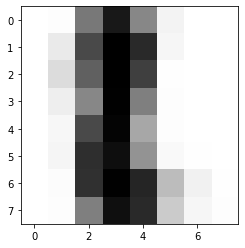

In [11]:
print(gen_labels[70])
plt.imshow(np.reshape(gen_samples[70],(8,8)), cmap=plt.cm.gray_r, interpolation='nearest')

In [12]:
np.save('gen_data.npy', gen_samples)
np.save('gen_labels.npy', gen_labels)

# 1. Experimenting on original samples only with RF (Baseline)

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=2, random_state=0)

y_train = train_data.iloc[:,-1:].copy().to_numpy()
x_train = train_data.iloc[:, 0:-1].copy().to_numpy()
y_test = test_data.iloc[:,-1:].copy().to_numpy()
x_test = test_data.iloc[:, 0:-1].copy().to_numpy()


In [14]:
rf.fit(x_train, y_train)
rf.score(x_test, y_test)

/tmp/ipykernel_10476/147419484.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)


0.800222593210907

In [15]:
pred_y = rf.predict(x_test)

In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_y))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       178
           1       0.77      0.43      0.55       182
           2       0.76      0.84      0.79       177
           3       0.71      0.90      0.79       183
           4       0.88      0.81      0.84       181
           5       0.93      0.71      0.81       182
           6       0.80      0.97      0.88       181
           7       0.75      0.92      0.83       179
           8       0.74      0.65      0.69       174
           9       0.80      0.78      0.79       180

    accuracy                           0.80      1797
   macro avg       0.81      0.80      0.79      1797
weighted avg       0.81      0.80      0.79      1797



In [17]:
x_train[1]

array([ 0,  0, 10, 16,  6,  0,  0,  0,  0,  7, 16,  8, 16,  5,  0,  0,  0,
       11, 16,  0,  6, 14,  3,  0,  0, 12, 12,  0,  0, 11, 11,  0,  0, 12,
       12,  0,  0,  8, 12,  0,  0,  7, 15,  1,  0, 13, 11,  0,  0,  0, 16,
        8, 10, 15,  3,  0,  0,  0, 10, 16, 15,  3,  0,  0])

## 2. Generated samples classification (only)

In [18]:
from sklearn.model_selection import train_test_split
x_gentrain,x_gentest, y_gentrain, y_gentest = train_test_split(
    gen_samples, gen_labels, test_size=0.25, random_state=42)


rf1 = RandomForestClassifier(max_depth=2, random_state=0)
rf1.fit(x_gentrain, y_gentrain)
rf1.score(x_gentest, y_gentest)

0.989375

In [19]:
pred_ygen = rf1.predict(x_gentest)
print(classification_report(y_gentest, pred_ygen))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       164
           1       1.00      0.92      0.96       180
           2       0.99      1.00      1.00       150
           3       1.00      1.00      1.00       171
           4       1.00      1.00      1.00       142
           5       0.98      0.98      0.98       154
           6       1.00      1.00      1.00       167
           7       1.00      1.00      1.00       155
           8       0.98      1.00      0.99       159
           9       0.94      1.00      0.97       158

    accuracy                           0.99      1600
   macro avg       0.99      0.99      0.99      1600
weighted avg       0.99      0.99      0.99      1600



## Discussion (Why High Accuracy)

The classification result on generated samples appeared higher by over 18 %. Next we try to normalize pixels before classification just to cverify that the results are not affected by the pixel values.


In [20]:
# normiziling pixel between 0..16 similar to the original data.
norm_xtrain = (16*(x_gentrain - np.min(x_gentrain))/np.ptp(x_gentrain)).astype(int) 
norm_xtest = (16*(x_gentest - np.min(x_gentest))/np.ptp(x_gentest)).astype(int) 

5


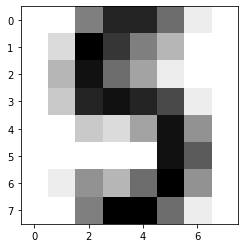

In [21]:
print(y_gentrain[1008])
plt.imshow(np.reshape(norm_xtrain[1008],(8,8)), cmap=plt.cm.gray_r, interpolation='nearest')

In [22]:
rf2 = RandomForestClassifier(max_depth=2, random_state=0)
rf2.fit(norm_xtrain, y_gentrain)
rf2.score(norm_xtest, y_gentest)

0.991875

In [23]:
pred_norm = rf2.predict(norm_xtest)
print(classification_report(y_gentest, pred_norm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       164
           1       1.00      0.96      0.98       180
           2       0.99      1.00      1.00       150
           3       1.00      1.00      1.00       171
           4       0.96      0.98      0.97       142
           5       0.99      0.99      0.99       154
           6       0.99      1.00      1.00       167
           7       0.99      1.00      0.99       155
           8       1.00      0.99      1.00       159
           9       0.99      1.00      0.99       158

    accuracy                           0.99      1600
   macro avg       0.99      0.99      0.99      1600
weighted avg       0.99      0.99      0.99      1600



The results appeared unchanged. Thus, pixel values/norm had zero effect on the results.

## 3.  Trained on real testing on generated

In [24]:
print('test accuracy : ', rf.score(norm_xtest, y_gentest))

test accuracy :  0.93375


In [25]:
pred_norm3 = rf.predict(norm_xtest)
print(classification_report(y_gentest, pred_norm3))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       164
           1       1.00      0.78      0.88       180
           2       0.97      1.00      0.99       150
           3       0.76      1.00      0.86       171
           4       0.96      0.91      0.93       142
           5       1.00      0.66      0.80       154
           6       0.93      1.00      0.96       167
           7       0.92      1.00      0.96       155
           8       0.90      0.99      0.95       159
           9       1.00      0.99      1.00       158

    accuracy                           0.93      1600
   macro avg       0.94      0.93      0.93      1600
weighted avg       0.94      0.93      0.93      1600



## 4. Trained on generated --> testing on real

In [26]:
print('test accuracy : ', rf2.score(x_test, y_test))

test accuracy :  0.7590428491930996


In [27]:
pred_y4 = rf2.predict(x_test)
print(classification_report(y_test, pred_y4))

              precision    recall  f1-score   support

           0       0.70      0.98      0.82       178
           1       0.80      0.59      0.68       182
           2       0.63      0.89      0.74       177
           3       0.81      0.79      0.80       183
           4       0.80      0.87      0.83       181
           5       0.74      0.76      0.75       182
           6       0.82      0.96      0.89       181
           7       0.74      0.93      0.82       179
           8       0.89      0.43      0.58       174
           9       0.84      0.39      0.53       180

    accuracy                           0.76      1797
   macro avg       0.78      0.76      0.74      1797
weighted avg       0.78      0.76      0.74      1797



## Discussion 

The results indicated that the original samples where more difficult to classify. Performances where both diminishing whether the model was trained on original or generated sample.

## 5. Combine train from generated and real samples

In [28]:
X = np.concatenate([x_train, norm_xtrain])
Y = np.concatenate([np.reshape(y_train, -1), y_gentrain])

RF = RandomForestClassifier(max_depth=2, random_state=0)
RF.fit(X, Y)

RandomForestClassifier(max_depth=2, random_state=0)

In [29]:
print('Real test accuracy : ', RF.score(x_test, y_test))
print('Generated accuracy : ', RF.score(norm_xtest, y_gentest))

Real test accuracy :  0.7896494156928213
Generated accuracy :  0.9775


In [30]:
pred_y5 = RF.predict(x_test)
print('real classification report\n',classification_report(y_test, pred_y5))

real classification report
               precision    recall  f1-score   support

           0       0.86      0.99      0.92       178
           1       0.81      0.36      0.50       182
           2       0.66      0.89      0.76       177
           3       0.73      0.90      0.81       183
           4       0.85      0.85      0.85       181
           5       0.85      0.77      0.81       182
           6       0.83      0.97      0.90       181
           7       0.75      0.93      0.83       179
           8       0.81      0.51      0.63       174
           9       0.81      0.72      0.76       180

    accuracy                           0.79      1797
   macro avg       0.80      0.79      0.78      1797
weighted avg       0.80      0.79      0.78      1797



In [31]:
pred_y5g = RF.predict(norm_xtest)
print('generated classification report\n',classification_report(y_gentest, pred_y5g))

generated classification report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       164
           1       1.00      0.93      0.96       180
           2       0.99      0.99      0.99       150
           3       0.93      1.00      0.96       171
           4       1.00      0.95      0.97       142
           5       1.00      0.91      0.95       154
           6       0.96      1.00      0.98       167
           7       0.96      1.00      0.98       155
           8       1.00      0.99      1.00       159
           9       0.95      1.00      0.98       158

    accuracy                           0.98      1600
   macro avg       0.98      0.98      0.98      1600
weighted avg       0.98      0.98      0.98      1600



In [32]:
##combine test results
x = np.concatenate([x_test, norm_xtest])
y = np.concatenate([np.reshape(y_test, -1), y_gentest])

In [33]:
print('Combined Accuracy : ', RF.score(x, y))
pred_y5c = RF.predict(x)
print('Combined classification report\n',classification_report(y, pred_y5c))

Combined Accuracy :  0.8781277597880482
Combined classification report
               precision    recall  f1-score   support

           0       0.92      0.99      0.96       342
           1       0.94      0.64      0.76       362
           2       0.79      0.94      0.86       327
           3       0.82      0.95      0.88       354
           4       0.92      0.89      0.90       323
           5       0.92      0.84      0.88       336
           6       0.89      0.99      0.94       348
           7       0.84      0.96      0.89       334
           8       0.92      0.74      0.82       333
           9       0.88      0.85      0.87       338

    accuracy                           0.88      3397
   macro avg       0.88      0.88      0.88      3397
weighted avg       0.88      0.88      0.88      3397



# MLP experiment

In [34]:
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Flatten
from tensorflow.keras.models import Sequential


def build_model(input_shape=(64,), num_classes=10):
    """

    :param input_shape: shape of input_data
    :param num_classes: number of classes
    :return: keras.model.sequential compiled with categorical cross-entropy loss
    """
    model = Sequential([
        Input(shape=input_shape),
        Dense(32, activation="relu"),
        BatchNormalization(),
        Dense(64, activation="relu"),
        BatchNormalization(),
        Flatten(),
        Dropout(0.5),
        Dense(num_classes, activation="softmax"),
    ])

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.summary()
    return model

In [35]:
model = build_model()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
__________________________________________________

In [54]:
batch_size=8
epochs=2
history = model.fit(train_images, train_y, batch_size=batch_size, epochs=epochs, validation_data=(test_images, test_y))

Train on 3823 samples, validate on 1797 samples
Epoch 1/2
3823/3823 [==============================] - 1s 215us/sample - loss: 0.2089 - acc: 0.9401 - val_loss: 0.1350 - val_acc: 0.9588
Epoch 2/2
3823/3823 [==============================] - 1s 215us/sample - loss: 0.1950 - acc: 0.9425 - val_loss: 0.1335 - val_acc: 0.9560


In [55]:
score = model.evaluate(test_images, test_y, verbose=0)

In [56]:
print('test loss: ',score[0])
print('test accuracy: ', score[1] )

test loss:  0.13348570649624059
test accuracy:  0.9560378


In [57]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [61]:
y_pred_oh = model.predict(test_images)
y_pred_baseline = y_pred_oh.argmax(axis=-1)
y_pred_baseline

array([0, 1, 8, ..., 8, 9, 8])

In [62]:
print('MLP classification report\n',classification_report(y_test, y_pred_baseline))

MLP classification report
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       178
           1       0.98      0.97      0.98       182
           2       1.00      0.93      0.96       177
           3       0.99      0.92      0.95       183
           4       0.99      0.99      0.99       181
           5       0.96      0.97      0.96       182
           6       0.96      0.99      0.98       181
           7       0.98      0.93      0.95       179
           8       0.86      0.91      0.89       174
           9       0.89      0.94      0.92       180

    accuracy                           0.96      1797
   macro avg       0.96      0.96      0.96      1797
weighted avg       0.96      0.96      0.96      1797



# Train on combined generated and test data

In [71]:
print(len(Y))
print(train_images[0])

8623
[0.     0.0625 0.375  0.9375 0.75   0.0625 0.     0.     0.     0.4375
 1.     0.375  0.375  0.625  0.     0.     0.     0.5    1.     0.125
 0.     0.6875 0.125  0.     0.     0.3125 1.     0.1875 0.     0.3125
 0.4375 0.     0.     0.4375 0.8125 0.1875 0.     0.5    0.4375 0.
 0.     0.25   0.75   0.     0.0625 0.8125 0.3125 0.     0.     0.
 0.875  0.5625 0.9375 0.5625 0.     0.     0.     0.     0.375  0.875
 0.4375 0.0625 0.     0.    ]


In [72]:
model_aug = build_model()
X_train = np.array(X).astype(np.float32) / 16.0
Y_oh = np.array(tf.keras.utils.to_categorical(Y, num_classes=10, dtype='float32'))
history_aug = model_aug.fit(X_train, Y_oh, batch_size=batch_size, epochs=epochs, validation_data=(test_images, test_y))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
batch_normalization_6 (Batch (None, 32)                128       
_________________________________________________________________
dense_10 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_7 (Batch (None, 64)                256       
_________________________________________________________________
flatten_3 (Flatten)          (None, 64)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)               

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


8623/8623 [==============================] - 2s 218us/sample - loss: 0.6864 - acc: 0.7907 - val_loss: 0.3025 - val_acc: 0.9082
Epoch 2/2
8623/8623 [==============================] - 2s 188us/sample - loss: 0.2602 - acc: 0.9266 - val_loss: 0.2233 - val_acc: 0.9382


In [73]:
y_pred_aug_oh = model_aug.predict(test_images)
y_pred_aug = y_pred_aug_oh.argmax(axis=-1)
print('Combined MLP classification report on real samples only.\n',classification_report(y_test, y_pred_aug))

Combined MLP classification report on real samples only.
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       178
           1       0.86      0.96      0.90       182
           2       0.97      0.99      0.98       177
           3       0.95      0.93      0.94       183
           4       0.97      0.95      0.96       181
           5       0.95      0.97      0.96       182
           6       0.97      0.97      0.97       181
           7       1.00      0.86      0.92       179
           8       0.92      0.82      0.87       174
           9       0.84      0.94      0.88       180

    accuracy                           0.94      1797
   macro avg       0.94      0.94      0.94      1797
weighted avg       0.94      0.94      0.94      1797

